Import necessari

In [1]:
#import standard
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

#import preprocessing
from tensorflow.keras.datasets import mnist

#per trasformare un intero rapresentante una classe in un array one hot encoded
from tensorflow.keras.utils import to_categorical

#import per il modello
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras import Input


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2,l1 

definizione di funzioni utili

In [18]:
def get_weights_nparray(model):
    
    weights = []
    for layer in model.layers:
        for M in layer.get_weights():
            for W in M:
                for w in W.flatten():
                    weights.append(w)

    #ora ho un ndarray con tutti i weights e bias
    weights = np.array(weights)
    
    return weights

def pruning(model, soglia_percentile = 100/33, minimum_weight = 2**-5):

    model_config = model.get_config()
    model_pruned = Sequential.from_config(model_config)
    
    
    weights = get_weights_nparray(model)
    
    total_weights = model.count_params()
    non_zero_weight = len(weights[weights != 0])
    print('initial non zero weights: ', non_zero_weight, ' su: ', total_weights)
    
    absolute_max = np.absolute(weights.max())
    #weights = np.absolute(weights/absolute_max)
    
    print('\npeso massimo: ',absolute_max)
    
    soglia = np.percentile(np.absolute(weights[weights != 0]), soglia_percentile)
    print('\nsoglia percentile: ',soglia, '\tsoglia min W: ', minimum_weight)
    if soglia < minimum_weight:
        soglia = minimum_weight
    
    print('\nsoglia: ',soglia)
    
    
    list_M_pruned = []
    
    for M in model.get_weights():
        #index_to_prune = np.logical_not(np.all([M < soglia, M > -soglia],axis=0))
        index_to_prune = np.all([M < soglia, M > -soglia],axis=0)
    
        M_pruned = np.copy(M)
    
        M_pruned[index_to_prune] = 0
    
        list_M_pruned.append(M_pruned)
    
    model_pruned.set_weights(list_M_pruned)
    
    weights = get_weights_nparray(model_pruned)
    non_zero_weight = len(weights[weights != 0])
    print('\nafter pruning non zero weights: ', non_zero_weight, ' su: ', total_weights)
    
    return model_pruned

def save_model(model, name):

    model.save('complete_model_' + name + '.h5')

    model_json_string = model.to_json()
    with open('model_' + name + '.json', 'w') as f:
        f.write(model_json_string)
    
    model.save_weights('model_weights_' + name + '.h5')

caricamento del dataset e preprocessing

In [2]:
#download mnist data and split into train and test sets
(X_train, y_train_int), (X_test, y_test_int) = mnist.load_data()

#one-hot encode target column
y_train = to_categorical(y_train_int)
y_test = to_categorical(y_test_int)

X_train[0].dtype

dtype('uint8')

In [3]:
#genero le immagini flat and zoom a 5-bit di color depth in scala di grigio

#-----USER DEFINED VALUES--------------------------- 

#dimensione taglio iniziale delle immagini originali che sono 28. 
#Questa procedura è un male necessario, vi è un tradeoff fra questa e size_final
size_initial = 20

#dimensione finale delle immagini
size_final = 8

#profondità pixel in bit
color_depth = 5

#---------------------------------------------------

X_train_flat_zoom = []
X_test_flat_zoom = []

X_train_flat_zoom_int = []
X_test_flat_zoom_int = []

#defisce gli indici del cropping definito da size_initial
bordo = (28-size_initial)//2
bordo_top = -bordo
if bordo == 0:
    bordo_top = None

    
#processing Training Set
for image in X_train:
    tmp = scipy.ndimage.zoom(image[bordo:bordo_top, bordo:bordo_top], size_final/size_initial).flatten()
    tmp = (tmp/(256//2**color_depth)).astype(int)
    X_train_flat_zoom.append(tmp/2**color_depth)
    X_train_flat_zoom_int.append(tmp)

#processing Test Set
for image in X_test:
    tmp = scipy.ndimage.zoom(image[bordo:bordo_top, bordo:bordo_top], size_final/size_initial).flatten()
    tmp = (tmp/(256//2**color_depth)).astype(int)
    X_test_flat_zoom.append(tmp/2**color_depth)
    X_test_flat_zoom_int.append(tmp)
    
X_train_flat_zoom = np.array(X_train_flat_zoom)
X_test_flat_zoom = np.array(X_test_flat_zoom)

X_train_flat_zoom_int = np.array(X_train_flat_zoom_int)
X_test_flat_zoom_int = np.array(X_test_flat_zoom_int)

(60000, 64)
int32


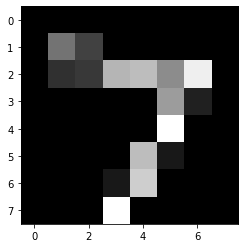

In [17]:

plt.imshow(X_test_flat_zoom_int[0].reshape((size_final,size_final)), cmap='gray')  

print (X_train_flat_zoom.shape)
print (X_train_flat_zoom_int.dtype)

In [4]:
#ENCODER
input = Input(shape=(X_train_flat_zoom_int.shape[-1],))
encoder = Dense(32, activation='relu')(input)
encoder = Dense(2, activation='relu')(encoder)

#DECODER
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='sigmoid')(decoder)

#AUTOENCODER
autoencoder = Model ( input, outputs=decoder)
autoencoder.compile(loss='mse', optimizer='adam')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
Total params: 4,354
Trainable params: 4,354
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = autoencoder.fit(X_train_flat_zoom, X_train_flat_zoom,
                            validation_data=(X_test_flat_zoom, X_test_flat_zoom),
                            batch_size = 256, epochs = 20,
                            shuffle = True
                             )

Epoch 1/20
235/235 [==============================] - 1s 5ms/step - loss: 0.1300 - val_loss: 0.1014
Epoch 2/20
235/235 [==============================] - 1s 4ms/step - loss: 0.0979 - val_loss: 0.0946
Epoch 3/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0930 - val_loss: 0.0911
Epoch 4/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0903 - val_loss: 0.0891
Epoch 5/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0885 - val_loss: 0.0876
Epoch 6/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0871 - val_loss: 0.0862
Epoch 7/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0856 - val_loss: 0.0847
Epoch 8/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0842 - val_loss: 0.0832
Epoch 9/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0829 - val_loss: 0.0820
Epoch 10/20
235/235 [==============================] - 1s 3ms/step - loss: 0.0817 - val_loss: 0.0810

Definizione dell'architettura NN e addestramento

In [90]:
model_flat_zoom = Sequential([
    Dense(32, input_shape=(X_train_flat_zoom.shape[-1],), activation='relu', kernel_regularizer=l2(0.01)),  
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.01))
                        ])

model_flat_zoom.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 10)                170       
Total params: 2,778
Trainable params: 2,778
Non-trainable params: 0
_________________________________________________________________


In [91]:
#epoche di training
training_epoch = 15

#compilazione del modello
model_flat_zoom.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#training del modello
history = model_flat_zoom.fit(x=X_train_flat_zoom_int, y=y_train, validation_data=(X_test_flat_zoom_int, y_test), epochs=training_epoch)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 36us/sample - loss: 1.4470 - acc: 0.7483 - val_loss: 0.6672 - val_acc: 0.8870
Epoch 2/15
60000/60000 [==============================] - 2s 33us/sample - loss: 0.5714 - acc: 0.8990 - val_loss: 0.4732 - val_acc: 0.92015890 - acc: 0 - ETA: 0s - loss: 0.5767 - acc: 0.89
Epoch 3/15
60000/60000 [==============================] - 2s 33us/sample - loss: 0.4650 - acc: 0.9176 - val_loss: 0.4244 - val_acc: 0.9262
Epoch 4/15
60000/60000 [==============================] - 2s 33us/sample - loss: 0.4307 - acc: 0.9260 - val_loss: 0.4236 - val_acc: 0.9271
Epoch 5/15
60000/60000 [==============================] - 2s 33us/sample - loss: 0.4179 - acc: 0.9283 - val_loss: 0.3962 - val_acc: 0.9353 0s - loss: 0.4158 - acc
Epoch 6/15
60000/60000 [==============================] - 2s 33us/sample - loss: 0.4082 - acc: 0.9316 - val_loss: 0.3996 - val_acc: 0.9331
Epoch 7/15
60000/60000 [==================

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Pruning del modello e verifica dell'accuratezza sul Test Set

In [92]:
model_flat_zoom_pruned = pruning(model_flat_zoom, minimum_weight=2**-5)

initial non zero weights:  2778  su:  2778

peso massimo:  0.972445

soglia percentile:  0.0005083537773426735 	soglia min W:  0.03125

soglia:  0.03125

after pruning non zero weights:  1527  su:  2778


C:\Users\Giordano\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log2
  
C:\Users\Giordano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Giordano\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([85., 72., 77., 90., 70., 79., 61., 51., 48., 37., 33., 27.,  9.,
        13.,  6.,  5.,  7.,  5.,  1.,  2.]),
 array([-4.999821  , -4.751846  , -4.50387   , -4.2558947 , -4.0079193 ,
        -3.7599437 , -3.5119684 , -3.2639928 , -3.0160172 , -2.7680418 ,
        -2.5200663 , -2.272091  , -2.0241153 , -1.7761399 , -1.5281644 ,
        -1.2801889 , -1.0322133 , -0.78423786, -0.5362624 , -0.28828692,
        -0.04031142], dtype=float32),
 <a list of 20 Patch objects>)

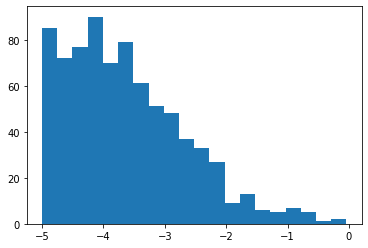

In [93]:
w_flat_zoom_pruned = np.absolute(get_weights_nparray(model_flat_zoom_pruned))
plt.hist(np.log2(w_flat_zoom_pruned[w_flat_zoom_pruned!=0]), bins=20)

In [94]:
model_flat_zoom_pruned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print('    Loss   Accuracy')
model_flat_zoom_pruned.test_on_batch(x=X_test_flat_zoom_int, y=y_test)

    Loss   Accuracy


[0.38490096, 0.9423]

Salvataggio del modello

In [95]:
name_model = 'MNIST_flat' + str(size_final) + '_' + str(color_depth) + 'bit'

save_model(model_flat_zoom, name_model)
save_model(model_flat_zoom_pruned, name_model + '_pruned')

Salvataggio delle immagini test da inserire nella FPGA

In [96]:
#lista contenente gli indici delle immagini campione nel Test Set del MNIST
#num_list[0] contiene l'indice dell'immagine di uno zero, num_list[1] di un uno e così via
#           0  1  2  3  4  5  6  7  8  9          
num_list = [3, 2, 1, 32,4, 15,21,0, 61,12]


#---------------------------------------------------------
#--FORMAT OF INPUT IMAGES FOR NN IN FPGA------------------
#----------- ap_fixed<7,2> -------------------------------
#---------------------------------------------------------

# last pixel                 first pixel
#[0  0  1  0  0  0  0 | ... | 0  0  0  1  0  0  0]
# s  0 -1 -2 -3 -4 -5         s  0 -1 -2 -3 -4 -5 
#    2  2  2  2  2  2            2  2  2  2  2  2

with open('TESTimg_downto_apfixed7_2.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write(str(index)+ ': ')
        for i in np.flip(X_test_flat_zoom_int[num]):
            f.write('{:07d}'.format(int((bin(i)[2:]))))
        f.write('\n\n')
        
        
#---------------------------------------------------------
#--FORMAT OF INPUT IMAGES FOR NN IN FPGA------------------
#----------- ap_int<7,2> -------------------------------
#---------------------------------------------------------

# last pixel              first pixel
#[0  1  0  0  0  0 | ... | 0  0  0  1  0  0]
# s  4  3  2  1  0         s  4  3  2  1  0 
#    2  2  2  2  2            2  2  2  2  2  
        
with open('TESTimg_downto_apint6.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write(str(index)+ ': ')
        for i in np.flip(X_test_flat_zoom_int[num]):
            f.write('{:06d}'.format(int((bin(i)[2:]))))
        f.write('\n\n')

Info dettagliate delle inferenze sulle immagini test inserite nella FPGA. 
Confronto fra modello completo e prunato.

In [97]:
print('predizioni del modello NON PRUNATO sulle immagini di test scelte\n\n\n')
for i,index in enumerate(num_list):
    print('number in image: ', i,'\nPrediction: ',model_flat_zoom.predict(X_test_flat_zoom_int[index].reshape(1,-1)))
    print('\n')

print('predizioni del modello PRUNATO sulle immagini di test scelte\n\n\n')
for i,index in enumerate(num_list):
    print('number in image: ', i,'\nPrediction: ',model_flat_zoom_pruned.predict(X_test_flat_zoom_int[index].reshape(1,-1)))
    print('\n')

predizioni del modello NON PRUNATO sulle immagini di test scelte





ValueError: Error when checking input: expected dense_9_input to have shape (64,) but got array with shape (1,)

Funzioni utili per la scrittura del codice vhdl di input.

Particolarmente verboso e quindi utile generarlo automaticamente

In [13]:
#lista contenente gli indici delle immagini campione nel Test Set del MNIST
#num_list[0] contiene l'indice dell'immagine di uno zero, num_list[1] di un uno e così via

n_image_test = 100

#           0  1  2  3  4  5  6  7  8  9          
num_list = [3, 2, 1, 32,4, 15,21,0, 61,12] + [x for x in range(62,62 + n_image_test - 10)]


#---------------------------------------------------------
#--FORMAT OF INPUT IMAGES FOR NN IN FPGA------------------
#----------- ap_fixed<7,2> -------------------------------
#---------------------------------------------------------

# last pixel                 first pixel
#[0  0  1  0  0  0  0 | ... | 0  0  0  1  0  0  0]
# s  0 -1 -2 -3 -4 -5         s  0 -1 -2 -3 -4 -5 
#    2  2  2  2  2  2            2  2  2  2  2  2

'''
with open('TESTimg_downto_apfixed7_2.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write(str(index)+ ': ')
        for i in np.flip(X_test_flat_zoom_int[num]):
            f.write('{:07d}'.format(int((bin(i)[2:]))))
        f.write('\n\n')
'''
        
#---------------------------------------------------------
#--FORMAT OF INPUT IMAGES FOR NN IN FPGA------------------
#----------- ap_int<7,2> -------------------------------
#---------------------------------------------------------

# last pixel              first pixel
#[0  1  0  0  0  0 | ... | 0  0  0  1  0  0]
# s  4  3  2  1  0         s  4  3  2  1  0 
#    2  2  2  2  2            2  2  2  2  2  

with open('TESTimg_downto_apint6_100imgs.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write('signal address_' + str(index) + ' : std_logic_vector((size-1) downto 0) := \"')
        for i in np.flip(X_test_flat_zoom_int[num]):
            f.write('{:06d}'.format(int((bin(i)[2:]))))
        f.write('\";\n')
        

#salvataggio dei true label associati alle immagini inserite nella FPGA
with open('TESTlabels_downto_apint6_100imgs.txt', 'w') as f:
    for index , num in enumerate(num_list):
        f.write('signal label_' + str(index) + ' : std_logic_vector(3 downto 0) := \"')
        f.write('{:04d}'.format(int((bin(y_test_int[num])[2:]))))
        f.write('\";\n')

In [1]:
#generazione di codice vhdl utile per il core di generazione di input nella FPGA

with open('vhdl_code_1.txt', 'w') as f:
    f.write('flat_image <= ')
    for i in range(n_image_test):
        f.write('address_' + str(i) + ' when (address = ' + str(i) + ') else\n')
    f.write('(others => \'0\');')
    
with open('vhdl_code_2.txt', 'w') as f:
    f.write('true_label <= ')
    for i in range(n_image_test):
        f.write('label_' + str(i) + ' when (address = ' + str(i) + ') else\n')
    f.write('(others => \'0\');')

NameError: name 'n_image_test' is not defined

Se si ha già il modello esportato e lo si vuole caricare per fare alcuni test.

In [1]:
from tensorflow.keras.models import load_model

load_model = load_model('complete_model_MNIST_flat8_5bit_pruned.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
#accuratezza del modello sulle immagini inserite nella FPGA

load_model.test_on_batch(x=X_test_flat_zoom_int[num_list], y=y_test[num_list])

[0.34578407, 0.97]

In [11]:
#Calcolo della latenza o tempo di inferenza sulla propria CPU, utilizzando le routine di Keras

import time

image  = X_test_flat_zoom_int[0].reshape(1,-1)
start_time = time.time()

load_model.predict(image)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0019826889038085938 seconds ---
